# Prepare Required Files and Dependencies

Full dataset is available at [https://ritsumei365-my.sharepoint.com/:u:/g/personal/gr0609fv_ed_ritsumei_ac_jp/EYS6Pu3_90ZLv9To2RgpEioBjpGQjUTMlks6IdPfT4ZlEA?e=kVuEfg](https://ritsumei365-my.sharepoint.com/:u:/g/personal/gr0609fv_ed_ritsumei_ac_jp/EYS6Pu3_90ZLv9To2RgpEioBjpGQjUTMlks6IdPfT4ZlEA?e=kVuEfg)

In [1]:
!git clone https://github.com/dmc27/missing_pixels.git

fatal: destination path 'missing_pixels' already exists and is not an empty directory.


In [2]:
from os import listdir
from os.path import isfile
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint

from utils import *

In [3]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

random.seed(42)

# Data Preparation

In [4]:
img_path = "datasets"
img_fnames = [f for f in listdir(img_path) if isfile(join(img_path, f))]
img_fnames = random.choices(img_fnames, k=1000)
print(img_fnames[:20])

['3527b667-4423-4fa5-bbdc-87857dd370f2.JPEG', '4cff3be4-dded-4b0a-97e8-abc0a3a964bf.JPEG', '42bf257b-e7eb-4c92-8774-1a7556282f4b.JPEG', '0580aed6-0069-4931-a9ab-af0c500c19a6.JPEG', 'bc88044b-adab-4f66-a5a4-b8b05dc83df2.JPEG', '5360e0a5-b441-4ba1-9565-8abda2ed3c9c.JPEG', '9db5086c-bbf0-46ea-8029-728f64291d39.JPEG', '166e1c7d-8008-435b-b9f0-90a684f3732e.JPEG', '6a18e5cd-3498-46f7-9c8a-b4011e1792d4.JPEG', 'a33c2a76-043f-4d2a-b18e-215626038746.JPEG', 'ed4123a4-ec53-49c2-adf4-7e125b6f0056.JPEG', '63f3f0d4-1554-49b7-a52b-896a300b484c.JPEG', '32cef872-6eb1-4295-abc1-4ab169284d5d.JPEG', '0bec73d2-61f9-4c15-bb18-fc8755201a71.JPEG', '7ea64000-424c-4063-8987-19450c42aec1.JPEG', '4d237abb-f780-442e-8d91-b26b8caa2fcd.JPEG', 'cfaf801e-6f3f-45de-880e-8b81c7190477.JPEG', '637a54ef-72ea-4e68-8339-05379bbc37be.JPEG', '871440c1-b10c-4afa-a4ed-8951b7e39b03.JPEG', 'f30572b2-5c1a-4a0a-bf4e-23b22bb2aeba.JPEG']


In [5]:
image_patches = []
targets = []

for img_fname in img_fnames:
    img = cv.imread(join(img_path, img_fname), cv.IMREAD_GRAYSCALE)
    img = img.astype(np.float64)

    for i in range(0, img.shape[0], BLOCK_SIZE):
        for j in range(0, img.shape[1], BLOCK_SIZE):
            patch = img[i:i+BLOCK_SIZE, j:j+BLOCK_SIZE]
            targets.append(patch[3:5, 3:5].flatten())

            patch[3:5, 3:5] = 0.0
            image_patches.append(patch)

In [6]:
X_train = np.array(image_patches) / 255.0
y_train = np.array(targets) / 255.0

In [7]:
X_train = X_train.reshape(-1, BLOCK_SIZE, BLOCK_SIZE, 1)

# Modeling

In [8]:
model_fname = "models/model.cnn.imagenet.h5"

model = Sequential([
    Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(BLOCK_SIZE, BLOCK_SIZE, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(NUM_OUT_NODES, activation='sigmoid')
])

model.compile(loss="mean_squared_error", optimizer="adam",
                metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 32)          832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 4, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 1, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4

2023-07-20 15:17:01.376499: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-07-20 15:17:01.376519: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2023-07-20 15:17:01.376522: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2023-07-20 15:17:01.376547: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-20 15:17:01.376560: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
checkpoint = ModelCheckpoint(model_fname, monitor='loss', verbose=1,
                             save_best_only=True)
callbacks_list = [checkpoint]

history = model.fit(X_train, y_train, epochs=450, batch_size=256,
                    validation_split=0.1, callbacks=callbacks_list)

Epoch 1/450
215/225 [===========================>..] - ETA: 0s - loss: 0.0087 - accuracy: 0.4535
Epoch 1: loss improved from inf to 0.00870, saving model to models/model.cnn.imagenet.h5
225/225 [==============================] - 1s 5ms/step - loss: 0.0087 - accuracy: 0.4533 - val_loss: 0.0092 - val_accuracy: 0.4652
Epoch 2/450
224/225 [============================>.] - ETA: 0s - loss: 0.0086 - accuracy: 0.4530
Epoch 2: loss improved from 0.00870 to 0.00865, saving model to models/model.cnn.imagenet.h5
225/225 [==============================] - 1s 5ms/step - loss: 0.0086 - accuracy: 0.4531 - val_loss: 0.0092 - val_accuracy: 0.4667
Epoch 3/450
217/225 [===========================>..] - ETA: 0s - loss: 0.0086 - accuracy: 0.4567
Epoch 3: loss improved from 0.00865 to 0.00861, saving model to models/model.cnn.imagenet.h5
225/225 [==============================] - 1s 5ms/step - loss: 0.0086 - accuracy: 0.4573 - val_loss: 0.0092 - val_accuracy: 0.4478
Epoch 4/450
218/225 [====================

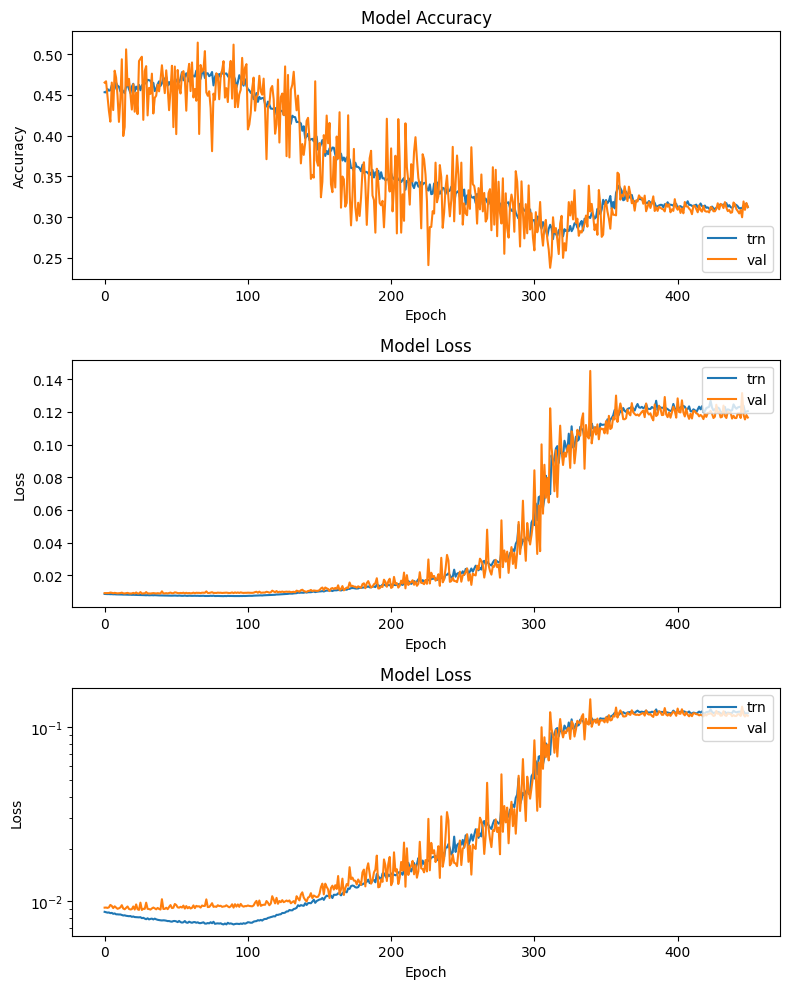

In [11]:
plot_training_history(history)

32/32 [==============================] - 0s 2ms/step
MSE = 290.22


2023-07-20 15:25:59.771912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


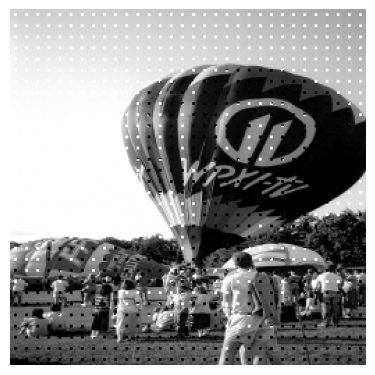

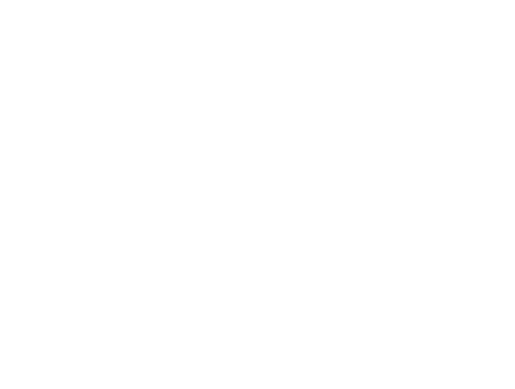

In [12]:
evaluate_cnn(model)